In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support


In [2]:
# Load the dataset from CSV
df = pd.read_csv(r"C:\Users\SAKSHEE\Downloads\relabelled_data5.csv")

# Extract texts and labels
texts = df['text'].astype(str).tolist()
labels = df['label'].tolist()

# Create a dictionary mapping emotions to indices
emotion_to_index = {emotion: idx for idx, emotion in enumerate(set(labels))}
index_to_emotion = {idx: emotion for emotion, idx in emotion_to_index.items()}

# Convert labels to indices
labels_indices = [emotion_to_index[label] for label in labels]

# Convert labels to one-hot encoding
num_classes = len(emotion_to_index)
labels_one_hot = to_categorical(labels_indices, num_classes=num_classes)

# Split data into training and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels_one_hot, test_size=0.2, random_state=42)

# Further split training data into training and validation sets
texts_train, texts_val, labels_train, labels_val = train_test_split(texts_train, labels_train, test_size=0.1, random_state=42)


In [3]:
# Define the TextVectorization layer
max_features = 10000  # Number of unique words
sequence_length = 50  # Maximum length of sequences

vectorize_layer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length)

# Adapt the TextVectorization layer on the training data
vectorize_layer.adapt(texts_train)
# Additional imports
from tensorflow.keras.layers import Dropout, LSTM

# Convert texts to tensors
train_texts_tensor = tf.constant(texts_train, dtype=tf.string)
val_texts_tensor = tf.constant(texts_val, dtype=tf.string)
test_texts_tensor = tf.constant(texts_test, dtype=tf.string)

# Define the updated model
model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_features, output_dim=128),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Added Dropout layer
    Dense(num_classes, activation='softmax')
])


In [4]:
# Compile the model with adjusted learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with more epochs
history = model.fit(train_texts_tensor, np.array(labels_train), epochs=10, validation_data=(val_texts_tensor, np.array(labels_val)))

# Evaluate the model on validation and test sets
val_results = model.evaluate(tf.constant(texts_val, dtype=tf.string), np.array(labels_val))
test_results = model.evaluate(tf.constant(texts_test, dtype=tf.string), np.array(labels_test))

print(f"Validation Loss: {val_results[0]}, Validation Accuracy: {val_results[1]}")
print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}")


Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6076 - loss: 0.8179 - val_accuracy: 0.9505 - val_loss: 0.1476
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9603 - loss: 0.1263 - val_accuracy: 0.9670 - val_loss: 0.0926
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9848 - loss: 0.0616 - val_accuracy: 0.9759 - val_loss: 0.0832
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9918 - loss: 0.0363 - val_accuracy: 0.9759 - val_loss: 0.1051
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9937 - loss: 0.0285 - val_accuracy: 0.9797 - val_loss: 0.1057
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9964 - loss: 0.0153 - val_accuracy: 0.9759 - val_loss: 0.1123
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9980 - loss: 0.0103 - val_accuracy: 0.9772 - val_loss: 0.1205
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9978 - loss: 0.0091 - val_acc

In [28]:
# Confusion Matrix and Classification Report
y_true = np.argmax(labels_test, axis=1)
y_pred = np.argmax(model.predict(tf.constant(texts_test, dtype=tf.string)), axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
[[981   0  18]
 [  0 150   8]
 [ 19   7 786]]


In [29]:

report = classification_report(y_true, y_pred, target_names=index_to_emotion.values())
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       happy       0.98      0.98      0.98       999
         sad       0.96      0.95      0.95       158
     neutral       0.97      0.97      0.97       812

    accuracy                           0.97      1969
   macro avg       0.97      0.97      0.97      1969
weighted avg       0.97      0.97      0.97      1969



In [12]:
# Example texts to predict
new_texts = [
    "I'm excited about starting my new job!",  # Happy
    "Oh, so sad",  # Sad
    "I have a routine day at work ahead."  # Neutral
]

new_texts_tensor = tf.constant(new_texts, dtype=tf.string)
predictions = model.predict(new_texts_tensor)

# Convert predictions to emotion labels
predicted_indices = np.argmax(predictions, axis=1)
predicted_emotions = [index_to_emotion[idx] for idx in predicted_indices]

# Output the results
for text, emotion in zip(new_texts, predicted_emotions):
    print(f"Text: '{text}' - Predicted Emotion: {emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Text: 'I'm excited about starting my new job!' - Predicted Emotion: happy
Text: 'Oh, so sad' - Predicted Emotion: sad
Text: 'I have a routine day at work ahead.' - Predicted Emotion: neutral


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


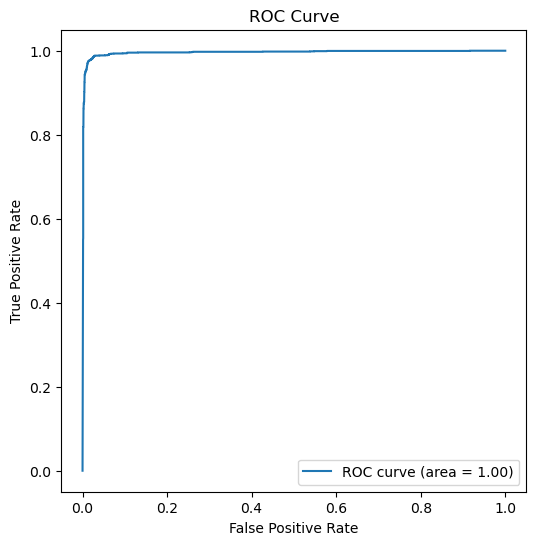

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve
labels_binarized = label_binarize(y_true, classes=np.arange(num_classes))
y_scores = model.predict(tf.constant(texts_test, dtype=tf.string))

fpr, tpr, _ = roc_curve(labels_binarized.ravel(), y_scores.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


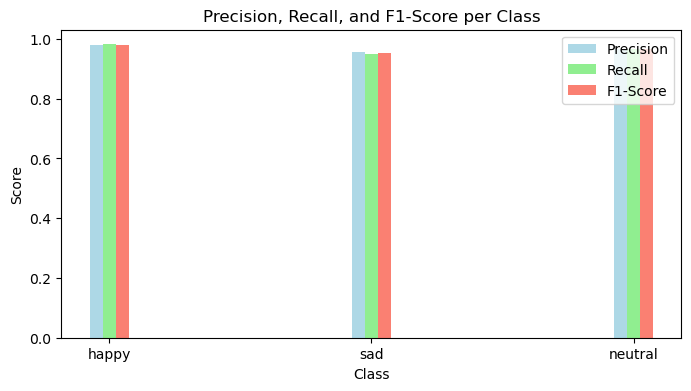

In [35]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

x = np.arange(len(precision))  # Label locations
width = 0.05  # Width of the bars

plt.figure(figsize=(8, 4))
plt.bar(x - width, precision, width, label='Precision', color='lightblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1_score, width, label='F1-Score', color='salmon')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.xticks(x, index_to_emotion.values())
plt.legend()
plt.show()


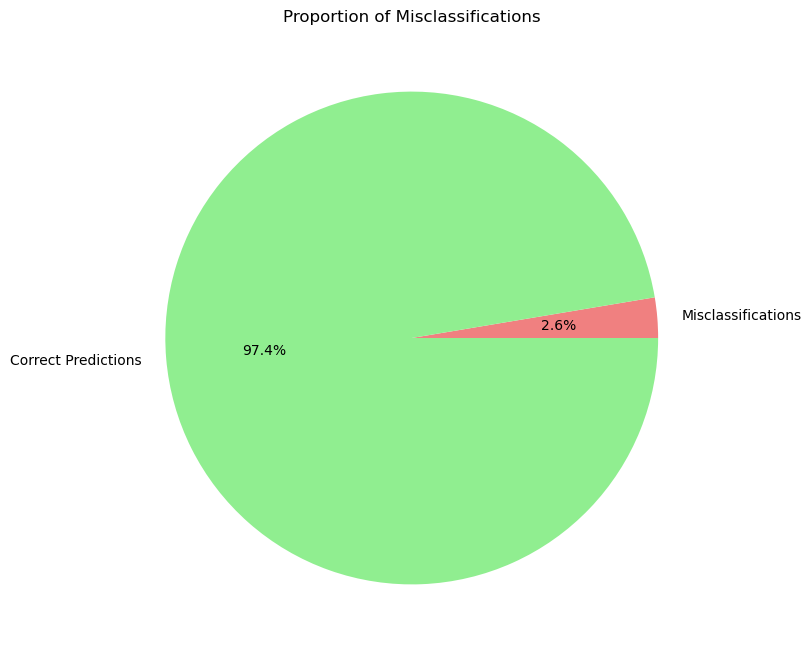

In [18]:
misclassifications = y_true != y_pred
misclassifications_count = sum(misclassifications)

plt.figure(figsize=(8, 8))
plt.pie([misclassifications_count, len(y_true) - misclassifications_count], 
        labels=['Misclassifications', 'Correct Predictions'], 
        autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Proportion of Misclassifications')
plt.show()


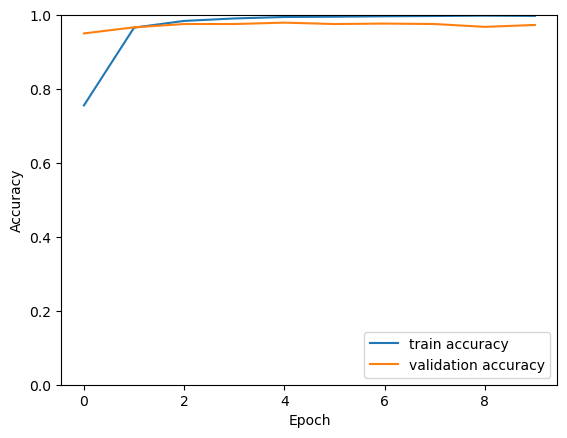

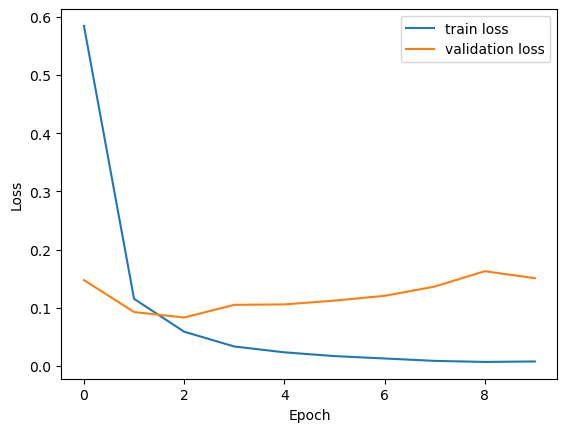

In [20]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

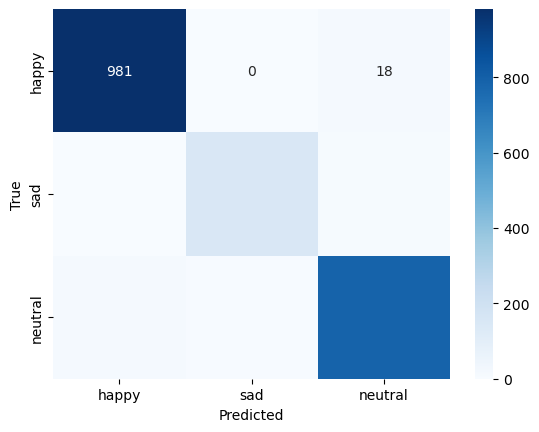

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=index_to_emotion.values(), yticklabels=index_to_emotion.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


              CNN      LSTM  Logistic Regression
happy    0.995382  0.995047             0.993807
sad      0.995929  0.995887             0.986101
neutral  0.993478  0.991909             0.971506


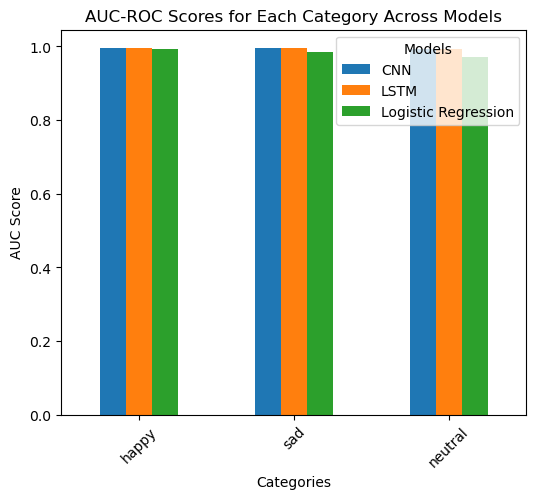

In [37]:
# Assuming y_true_bin is defined as the one-hot encoded labels for the test set
y_true_bin = np.array(labels_test)

# Compile all model predictions (CNN, LSTM, Logistic Regression)
model_predictions = {
    "CNN": cnn_predictions,
    "LSTM": lstm_predictions,
    "Logistic Regression": lr_predictions
}

# Calculate AUC-ROC for each model and category
auc_scores = {}
for model_name, predictions in model_predictions.items():
    auc_scores[model_name] = {}
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], predictions[:, i])
        auc_scores[model_name][index_to_emotion[i]] = auc(fpr, tpr)

# Convert the auc_scores dictionary to a DataFrame for easier plotting
auc_df = pd.DataFrame(auc_scores)

# Display the DataFrame
print(auc_df)

# Plotting the AUC scores for each category across models
auc_df.plot(kind='bar', figsize=(6, 5))
plt.title('AUC-ROC Scores for Each Category Across Models')
plt.xlabel('Categories')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.show()
